In [13]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import xml.etree.ElementTree as ET
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [14]:
DATASET_DIR = "."
IMAGES_DIR = "./road-sign-detection/images"
ANN_DIR = "./road-sign-detection/annotations"

print("Nb d'images :", len(os.listdir(IMAGES_DIR)))
print("Nb d'annotations :", len(os.listdir(ANN_DIR)))


Nb d'images : 877
Nb d'annotations : 877


In [15]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    objects = []
    
    for obj in root.findall("object"):
        name = obj.find("name").text
        bnd = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)
        objects.append({
            "label": name,
            "bbox": (xmin, ymin, xmax, ymax)
        })
    
    return filename, objects


In [23]:
IMG_SIZE = 96
X = []
y = []

xml_files = sorted(glob.glob(ANN_DIR + "/*.xml"))
for xml_path in xml_files:
    filename, objects = parse_voc_xml(xml_path)
    img_path = IMAGES_DIR + "/" + filename
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("RGB")
    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]
        crop = img.crop((xmin, ymin, xmax, ymax))
        crop = crop.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(crop))
        y.append(label)
X = np.array(X)
y = np.array(y)

print("Images extraites :", X.shape)
print("Labels :", np.unique(y))


Images extraites : (1244, 96, 96, 3)
Labels : ['crosswalk' 'speedlimit' 'stop' 'trafficlight']


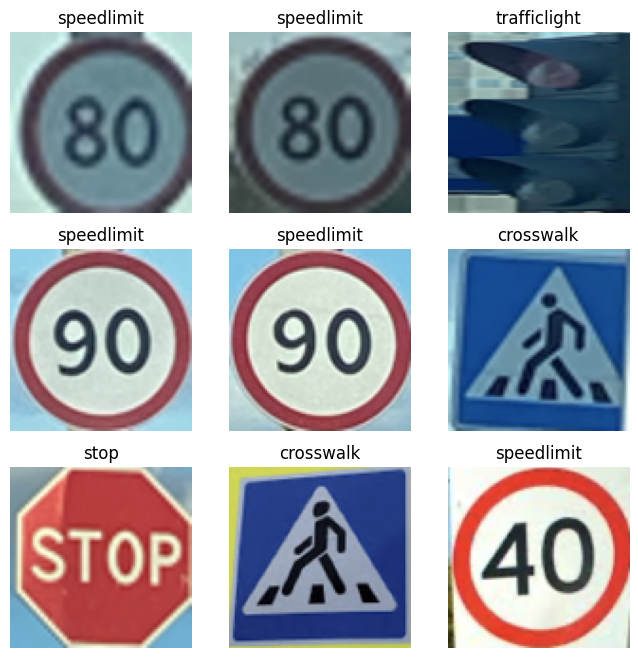

In [24]:
plt.figure(figsize=(8,8))
for i in range(9):
    idx = random.randint(0, len(X)-1)
    plt.subplot(3,3,i+1)
    plt.imshow(X[idx].astype("uint8"))
    plt.title(y[idx])
    plt.axis('off')
plt.show()


In [ ]:
X = X.astype("float32") / 255.0
# Aplatir les images pour les utiliser avec Random Forest
X_flat = X.reshape(X.shape[0], -1)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)
print("Classes :", label_encoder.classes_)


Train : (995, 27648) (995,)
Test  : (249, 27648) (249,)
Classes : ['crosswalk' 'speedlimit' 'stop' 'trafficlight']


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Entraînement du Random Forest...")
model.fit(X_train, y_train)
print("Modèle entraîné!")


Entraînement du Random Forest...
Modèle entraîné!
Modèle entraîné!


In [ ]:
y_pred = model.predict(X_test)
acc = np.mean(y_pred == y_test)
print(f"Accuracy test : {acc}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy test : 0.963855421686747

Rapport de classification :
              precision    recall  f1-score   support

   crosswalk       0.97      0.95      0.96        40
  speedlimit       0.97      0.98      0.98       157
        stop       1.00      0.89      0.94        18
trafficlight       0.89      0.94      0.91        34

    accuracy                           0.96       249
   macro avg       0.96      0.94      0.95       249
weighted avg       0.96      0.96      0.96       249



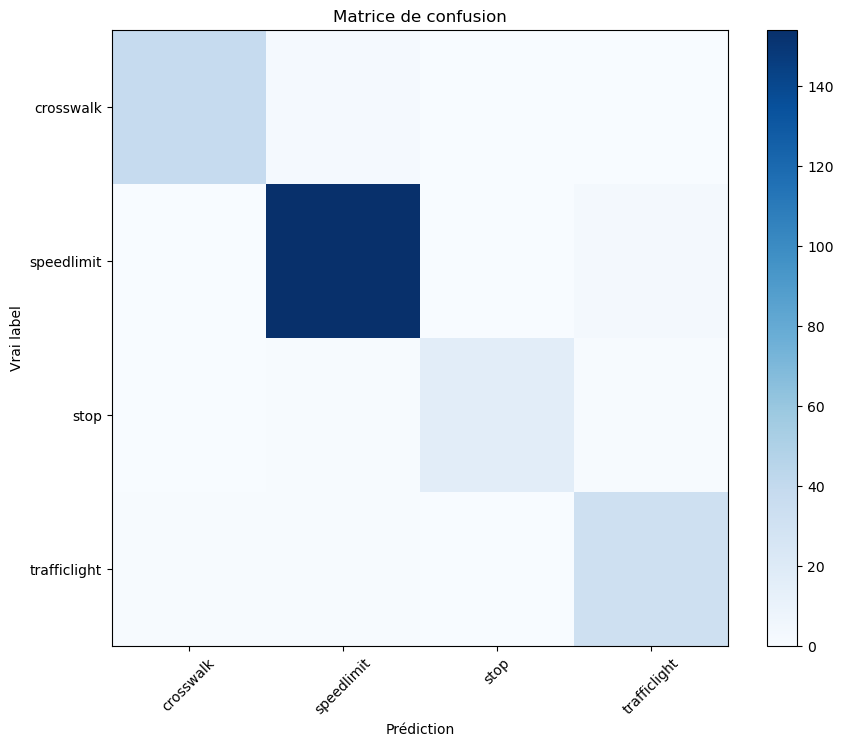

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Matrice de confusion')
plt.colorbar()
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.show()


In [ ]:
print(f"Accuracy finale : {acc:.4f}")


Accuracy finale : 0.9639


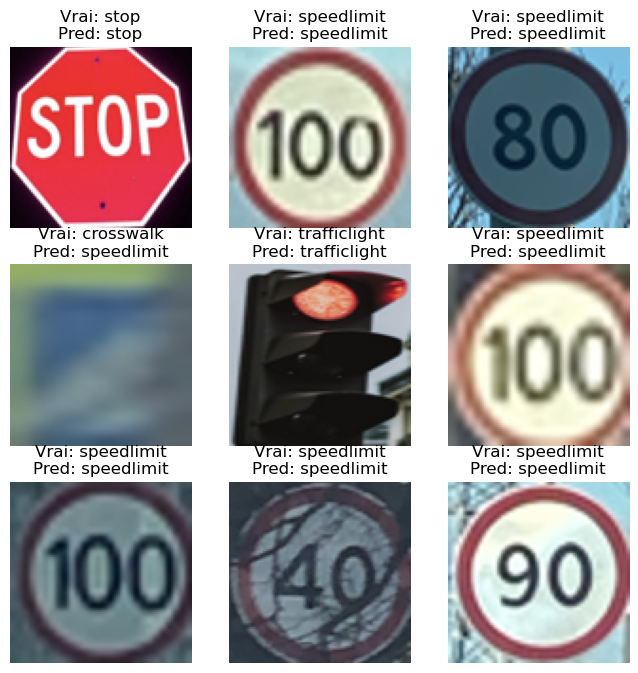

In [ ]:
indices = np.random.randint(0, len(X_test), 9)

plt.figure(figsize=(8,8))
for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[idx].reshape(IMG_SIZE, IMG_SIZE, 3))
    pred = model.predict([X_test[idx]])[0]
    pred_label = label_encoder.inverse_transform([pred])[0]
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]

    plt.title(f"Vrai: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.show()
